In [1]:
# import sys
# !{sys.executable} -m pip install tabulate
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
import janitor
import tabulate
from tqdm import tqdm
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
print(tf.__version__)

2.7.0


In [3]:
# set definitions
glacier = gl.data_loader(pth = '/data/fast1/glacierml/T_models/')
# ,TT,TTT,TTTx,TTT_full
# T_t = T.head()

# rename thickness column in database
gl.thickness_renamer(glacier)

# split data for training and validation
(train_features, test_features, train_labels, test_labels) = gl.data_splitter(glacier)

# define model hyperparameters
LR = np.logspace(-3,2,6)
vs = 0.2
VS = 0.1,0.15,0.2,0.25,0.3,0.35,0.4
RS = range(0,25,1)
ep = 300

# name databases
glacier.name = 'glacier'
# T_t.name = 'T_t'
# TT.name = 'band'
# TTT.name = 'point'
# TTTx.name = 'TTTx'
# TTT_full.name = 'TTT_full'

# old definitions, legacy code.

# arch = '16-8'
# pth_mod = 'sm/sm_' + arch + '/'
# pth_res = 'sr/sr_' + arch + '/'

Importing data...
Importing T database
Import complete


In [4]:
"""
This cell contains code to evaluate models and make predictions, then display the zults
"""
rootdir = 'sm/'
ext = ('.csv')
# print(rootdir)
dnn_model={}
predictions = pd.DataFrame()

for arch in tqdm(os.listdir(rootdir)):
    for folder in os.listdir(rootdir+arch):
        if 'MULTI' in folder:
            if 'dnn' in folder:
                dnn_model[arch[3:]+'_'+folder] = tf.keras.models.load_model(rootdir 
                    + arch 
                    + '/' 
                    + folder)
                
                mae_test = dnn_model[arch[3:]+'_'+folder].evaluate(test_features,
                                                             test_labels,verbose=0)
                
                mae_train = dnn_model[arch[3:]+'_'+folder].evaluate(train_features,
                                             train_labels,verbose=0)
                
                pred_train = dnn_model[arch[3:]+'_'+folder].predict(train_features)
                
                pred_test = dnn_model[arch[3:]+'_'+folder].predict(test_features)
#                 y = np.concatenate([pred_train,pred_test])
                avg_thickness = pd.Series((np.sum(pred_train) / len(pred_train)), name = 'avg train thickness')
                
                avg_test_thickness = pd.Series((np.sum(pred_test) / len(pred_test)),  name = 'avg test thickness')
                temp_df = pd.merge(avg_thickness, avg_test_thickness, right_index=True, left_index=True)
                predictions = predictions.append(temp_df, ignore_index=True)
                predictions.loc[predictions.index[-1], 'model']= folder
                predictions.loc[predictions.index[-1], 'test mae']= mae_test
                predictions.loc[predictions.index[-1], 'train mae']= mae_train
                predictions.loc[predictions.index[-1], 'architecture']= arch[3:]
predictions.rename(columns = {0:'avg train thickness'},inplace = True)

# these models are ridiculous, so we drop them.
idx = predictions.index[predictions['architecture']=='64']
predictions = predictions.drop(predictions.loc[idx].index)
# print(predictions.to_markdown())                

"""
Here we compute for each layer architecture avg mae, mae std dev, and
prediction std dev.
"""
deviations = pd.DataFrame()
for architecture in list(predictions['architecture'].unique()):
    
    # define temp dataframe for calculations that contains only one layer architecture
    df = predictions[predictions['architecture'] == architecture]
    
    # step 1: calculate mean of numbers
    test_mae_mean = np.sum(df['test mae']) / len(df) 

    diff_sq = pd.Series()
    
    for test_mae in df['test mae']:
        # step 2: subtract the mean from each, then square the result
        step_2 = pd.Series((test_mae - test_mae_mean)**2)
        diff_sq = diff_sq.append(step_2, ignore_index=True)
        
    # step 3: work out the mean of the squared differences    
    mean_diff_sq = (np.sum(diff_sq) / len(diff_sq))
    
    # step 4: take the square root
    test_mae_std_dev = np.sqrt(mean_diff_sq)
    
    
   # repeat for train mae 
    
    # step 1: calculate mean of numbers
    train_mae_mean = np.sum(df['train mae']) / len(df) 

    diff_sq = pd.Series()
    
    for train_mae in df['train mae']:
        # step 2: subtract the mean from each, then square the result
        step_2 = pd.Series((train_mae - train_mae_mean)**2)
        diff_sq = diff_sq.append(step_2, ignore_index=True)
        
    # step 3: work out the mean of the squared differences    
    mean_diff_sq = (np.sum(diff_sq) / len(diff_sq))
    
    # step 4: take the square root
    train_mae_std_dev = np.sqrt(mean_diff_sq)
    
    # repeat process for train thicknesses
    thickness_train_mean = np.sum(df['avg train thickness']) / len(df)   
    for thickness in df['avg train thickness']:
        step_2 = pd.Series((thickness - thickness_train_mean)**2)
        diff_sq = diff_sq.append(step_2, ignore_index=True)
    mean_diff_sq = (np.sum(diff_sq) / len(diff_sq))
    train_thickness_std_dev = np.sqrt(mean_diff_sq)
    
    
    # repeat process for test thicknesses
    thickness_test_mean = np.sum(df['avg test thickness']) / len(df)   
    for thickness in df['avg test thickness']:
        step_2 = pd.Series((thickness - thickness_test_mean)**2)
        diff_sq = diff_sq.append(step_2, ignore_index=True)
    mean_diff_sq = (np.sum(diff_sq) / len(diff_sq))
    test_thickness_std_dev = np.sqrt(mean_diff_sq)
    
    # turn the last number computed into a series so it may be appended to build the table.
    # it will be dropped later, no worries.
    test_thick_std_dev = pd.Series(test_thickness_std_dev)
    
    deviations = deviations.append(test_thick_std_dev, ignore_index=True)
    deviations.loc[deviations.index[-1], 'layer architecture']= architecture
    deviations.loc[deviations.index[-1], 'model parameters'] = dnn_model[architecture + '_glacier_dnn_MULTI_0.1_0.2_300_0'].count_params()
    deviations.loc[deviations.index[-1], 'test mae avg'] = test_mae_mean
    deviations.loc[deviations.index[-1], 'train mae avg']= train_mae_mean
    deviations.loc[deviations.index[-1], 'test mae std dev']= test_mae_std_dev
    deviations.loc[deviations.index[-1], 'train mae std dev']= train_mae_std_dev
    deviations.loc[deviations.index[-1], 'test predicted thickness std dev']= test_thickness_std_dev
    deviations.loc[deviations.index[-1], 'train predicted thickness std dev']= train_thickness_std_dev
# bootstrapped ensembles for predicted column    
#drop that appended line from earlier. Probably a better way to go about it
deviations.drop(columns = {0},inplace = True)    
deviations.sort_values('test mae avg')

100%|██████████| 17/17 [03:23<00:00, 11.99s/it]


,layer architecture,model parameters,test mae avg,train mae avg,test mae std dev,train mae std dev,test predicted thickness std dev,train predicted thickness std dev
7,16-8,234.0,32.222112,11.185435,15.672680,0.781699,11.355721,2.016813
9,16-10,270.0,36.024810,11.227334,24.742688,1.040625,15.684682,2.046897
8,20-10,330.0,36.684168,11.496173,14.202592,1.278700,10.680337,3.192789
0,12-6-3,172.0,43.009678,11.580006,26.626463,1.937355,18.220395,2.425202
6,16-4,162.0,43.577870,11.656853,31.413210,1.234964,19.864055,2.447538
13,12-12,238.0,45.322772,11.870251,22.462913,1.256479,14.430678,2.799342
11,16-6,198.0,45.996561,11.689291,30.385058,1.121671,20.223611,2.061004
10,12-8,182.0,50.875385,11.734783,31.989574,1.095910,19.970084,2.007298
1,12-6,154.0,52.556535,12.016238,29.897222,2.022535,18.720065,2.426674
4,8-4-2,98.0,52.665127,15.672720,35.395604,3.879644,23.759894,3.316205


In [5]:
dnn_model['4-2_glacier_dnn_MULTI_0.1_0.2_300_0'].summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 dense_17 (Dense)            (None, 4)                 20        
                                                                 
 dense_18 (Dense)            (None, 2)                 10        
                                                                 
 dense_19 (Dense)            (None, 1)                 3         
                                                                 
Total params: 42
Trainable params: 33
Non-trainable params: 9
_________________________________________________________________


In [6]:
deviations.sort_values('test mae avg')

,layer architecture,model parameters,test mae avg,train mae avg,test mae std dev,train mae std dev,test predicted thickness std dev,train predicted thickness std dev
7,16-8,234.0,32.222112,11.185435,15.672680,0.781699,11.355721,2.016813
9,16-10,270.0,36.024810,11.227334,24.742688,1.040625,15.684682,2.046897
8,20-10,330.0,36.684168,11.496173,14.202592,1.278700,10.680337,3.192789
0,12-6-3,172.0,43.009678,11.580006,26.626463,1.937355,18.220395,2.425202
6,16-4,162.0,43.577870,11.656853,31.413210,1.234964,19.864055,2.447538
13,12-12,238.0,45.322772,11.870251,22.462913,1.256479,14.430678,2.799342
11,16-6,198.0,45.996561,11.689291,30.385058,1.121671,20.223611,2.061004
10,12-8,182.0,50.875385,11.734783,31.989574,1.095910,19.970084,2.007298
1,12-6,154.0,52.556535,12.016238,29.897222,2.022535,18.720065,2.426674
4,8-4-2,98.0,52.665127,15.672720,35.395604,3.879644,23.759894,3.316205


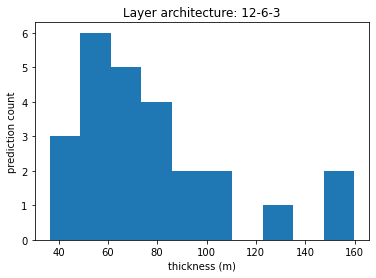

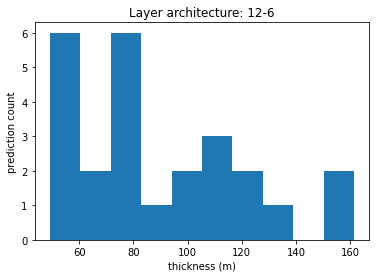

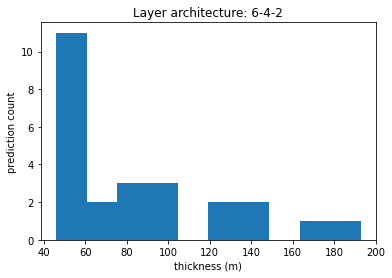

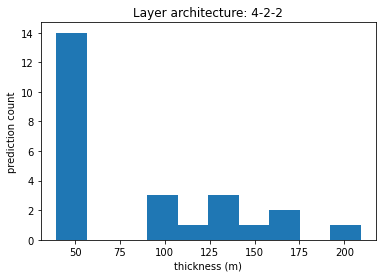

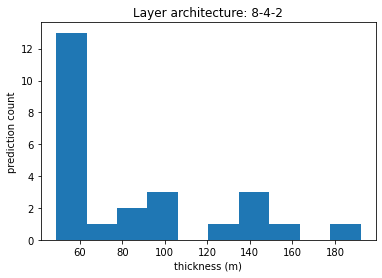

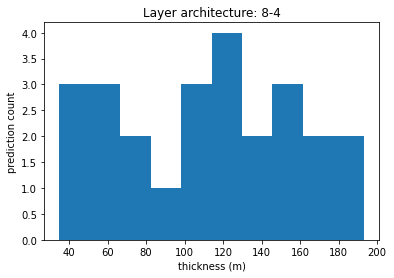

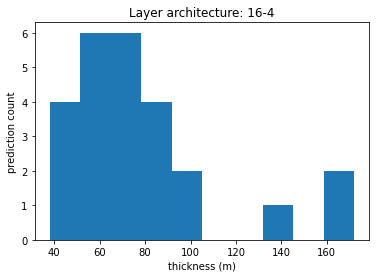

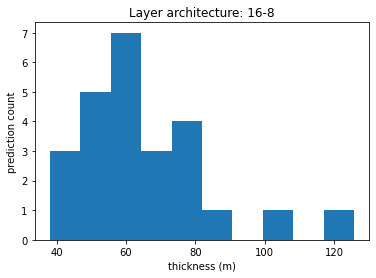

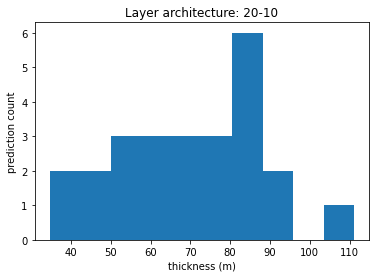

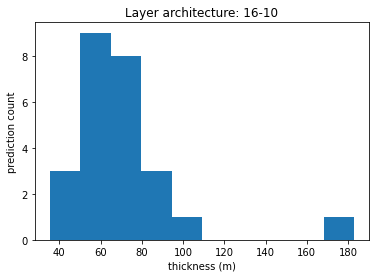

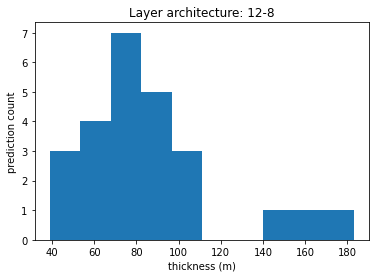

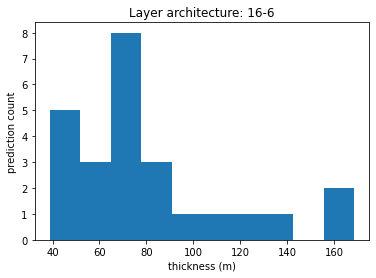

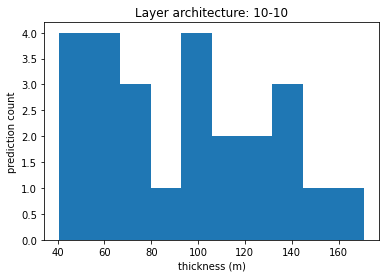

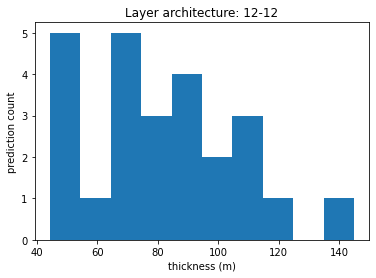

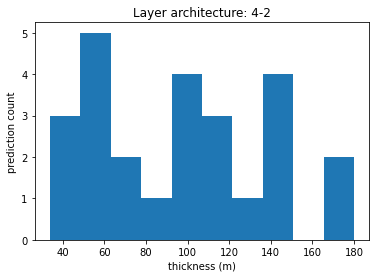

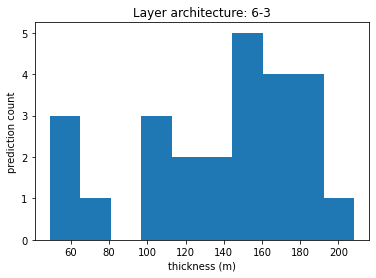

In [7]:
"""
This cell contains code to produce histograms of all the architectures different histories
"""

for architecture in list(predictions['architecture'].unique()):
    df = predictions[predictions['architecture'] == architecture]
    fig,ax = plt.subplots()
    ax.set_title('Layer architecture: ' + architecture)
    ax.set_ylabel('prediction count')
    ax.set_xlabel('thickness (m)')
    fig.patch.set_facecolor('w')
    plt.hist(df['avg test thickness'])
# print(df)

In [8]:
df

,avg train thickness,avg test thickness,model,test mae,train mae,architecture
412,41.870445,143.456820,glacier_dnn_MULTI_0.1_0.2_300_0,107.004616,14.655035,6-3
413,42.990057,73.131841,glacier_dnn_MULTI_0.1_0.2_300_1,38.347095,12.311481,6-3
414,44.340232,114.794378,glacier_dnn_MULTI_0.1_0.2_300_2,76.357353,13.837061,6-3
415,51.328502,157.216153,glacier_dnn_MULTI_0.1_0.2_300_3,116.398186,13.571522,6-3
416,52.537087,208.199507,glacier_dnn_MULTI_0.1_0.2_300_4,171.033005,13.778233,6-3
417,49.246943,49.246937,glacier_dnn_MULTI_0.1_0.2_300_5,28.339516,20.193043,6-3
418,49.005238,49.005238,glacier_dnn_MULTI_0.1_0.2_300_6,28.229652,20.182056,6-3
419,47.240146,190.167037,glacier_dnn_MULTI_0.1_0.2_300_7,148.613342,13.341063,6-3
420,45.015417,136.294212,glacier_dnn_MULTI_0.1_0.2_300_8,99.259552,13.916233,6-3
421,47.036987,174.778209,glacier_dnn_MULTI_0.1_0.2_300_9,136.205841,13.943545,6-3


In [9]:
ccccombo_breaker()
# past this point is under construction. 
# here be monsters

NameError: name 'ccccombo_breaker' is not defined

In [ ]:
# load all histories
print('Loading histories....')
rootdir = 'sr/'
dnn_history = {}
for arch in tqdm(os.listdir(rootdir)):
    for folder in os.listdir(rootdir+arch):
        if 'MULTI' in folder:
            if 'dnn' in folder:

                dnn_history[arch[3:] + '_'+ folder] = pd.read_csv(rootdir+arch+'/'+folder)
# dnn_history

In [ ]:
# dnn_modl
arch

In [ ]:
"""
This code plots predictions against actual thickness. Not currently modified and will load
EVERY SINGLE MODEL. DO NOT USE JUST YET
"""
# for modl in dnn_modl:    
#     y = dnn_modl[modl].predict(test_features)
#     fig,ax=plt.subplots(1,1,figsize=(15,10))
#     fig.patch.set_facecolor('w')
#     plt.plot(test_labels,y,'.')
#     plt.plot((0,300),(0,300),'-')
#     plt.xlabel('True Thickness (m)')
#     plt.ylabel('Model Thickness (m)')
#     plt.xlim((0,300))
#     plt.ylim((0,300))
#     # plt.savefig("/home/sa42/notebooks/glac/figs/GTP_T")

In [ ]:
"""
This is a density plot of the most recent predictions made. Can easily be modified in a loop
to show multiple random states and whatnot
"""
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,300),(0,300),'-')

In [ ]:
"""
This cell plots the different variable loss curves to show individual variable models
Not currently working because we have only loaded dnn_MULTI models
"""
fig,ax=plt.subplots(2,2,figsize=(10,10))
fig.patch.set_facecolor('w')
# ax.set_ylim([5,30])

# gl.plot_loss(dnn_history['T_MULTI'])
for i, variable_name in enumerate(list(train_features)):
    ax = plt.subplot(2,2,i+1)
    gl.plot_loss(dnn_history['glacier_'+ variable_name+ '_0.1_0.2_300_6'])
#     ax.set_ylim([35,140])
    ax.set_title(variable_name)
    plt.tight_layout()
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")


In [ ]:
# load all histories
print('Loading histories....')
rootdir = 'sr/'
dnn_history = {}
for arch in tqdm(os.listdir(rootdir)):
    for folder in os.listdir(rootdir+arch):
        if 'MULTI' in folder:
            if 'dnn' in folder:

                dnn_history[arch[3:] + '_'+ folder] = pd.read_csv(rootdir+arch+'/'+folder)
dnn_history

In [ ]:
arch

In [ ]:
"""
This cell plots each random state loss curve for the 25 random states for each run
Also loads EVERY SINGLE MODEL currently and blows up the memory. Working on it.
"""
for hist in dnn_history:    
    fig,ax=plt.subplots(1,1,figsize=(10,10))
    fig.patch.set_facecolor('w')
    ax.set_title(hist)
    gl.plot_loss(dnn_history[hist])
    # plt.savefig("/home/sa42/notebooks/glac/figs/GTP_dnn_loss.eps")

In [ ]:
# def plot_single_variable(x,y,model_type,model_name,feature_name):
#     y = model_type[model_name].predict(test_labels)
#     plt.scatter(train_features[feature_name], train_labels, label='Data')
#     plt.plot(x, y,'.', color='k', label='Predictions')
#     plt.xlabel(feature_name)
#     plt.ylabel('THICKNESS')
#     plt.legend()
#     plt.plot()

# x = test_labels
# for i, variable_name in enumerate(list(train_features)):
#     ax = plt.subplot(2,2,i+1)
#     model_name = (dataset.name 
#     + '_' 
#     + variable_name 
#     + '_' 
#     + str(lr) 
#     + '_' 
#     + str(vs) 
#     + '_' 
#     + str(ep))
#     plot_single_variable(x,y,dnn_model, model_name,variable_name)
# #     ax.set_ylim([35,140])
# #     ax.set_title(variable_name)
# #     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
# plt.tight_layout()

In [ ]:
# """
# This cell contains code to load models and histories.
# """

# # fix hyperparameters 
# lr = 0.1
# vs = 0.2
# # load models
# print('Loading models....')

# linear_model = {}
# dnn_model = {}
# # data is already split, however if other databases are used, then this line is needed
# # (train_features, test_features, train_labels, test_labels) = gl.data_splitter(glacier)
# for variable_name in tqdm(list(train_features) + ['MULTI']):
#     for rs in RS:
#         file_name = (
#         pth_mod 
#         + 'glacier' 
#         + '_linear_' 
#         + variable_name 
#         + '_' 
#         + str(lr)
#         + '_'
#         + str(vs)
#         + '_'
#         + str(ep)
#         + '_'
#         + str(rs)
#         )

#         linear_model[
#             'glacier' 
#             + '_' 
#             + variable_name 
#             + '_' 
#             + str(lr)
#             + '_'
#             + str(vs)
#             + '_'
#             + str(ep)
#             + '_'
#             + str(rs)
#         ] = tf.keras.models.load_model(file_name)
        
# for variable_name in tqdm(list(train_features) + ['MULTI']):
#     for rs in RS:
#         file_name = (
#         pth_mod 
#         + 'glacier' 
#         + '_dnn_' 
#         + variable_name 
#         + '_' 
#         + str(lr)
#         + '_'
#         + str(vs)
#         + '_'
#         + str(ep)
#         + '_'
#         + str(rs)
#         )

#         dnn_model[
#             'glacier'
#             + '_' 
#             + variable_name 
#             + '_' 
#             + str(lr)
#             + '_'
#             + str(vs)
#             + '_'
#             + str(ep)
#             + '_'
#             + str(rs)
#         ] = tf.keras.models.load_model(file_name)
# print('Models loaded')

# # load all histories
# print('Loading histories....')
# linear_history = {}
# dnn_history = {}
# for variable_name in tqdm(list(train_features) + ['MULTI']):
#     for rs in RS:
#         file_name = (
#             pth_res 
#             + 'glacier' 
#             +'_linear_history_'
#             + variable_name 
#             + '_' 
#             + str(lr)
#             + '_'
#             + str(vs)
#             + '_'
#             + str(ep)
#             + '_'
#             + str(rs)
#         )

#         linear_history[
#             'glacier' 
#             +'_'
#             + variable_name 
#             + '_' 
#             + str(lr)
#             + '_'
#             + str(vs)
#             + '_'
#             + str(ep)
#             + '_'
#             + str(rs)
#         ]= pd.read_csv(file_name)

# for variable_name in tqdm(list(train_features) + ['MULTI']):
#     for rs in RS:
#         file_name = (
#             pth_res 
#             + 'glacier_dnn_history_' 
#             + variable_name 
#             + '_' 
#             + str(lr)
#             + '_'
#             + str(vs)
#             + '_'
#             + str(ep)
#             + '_'
#             + str(rs)
#         )

#         dnn_history[
#             'glacier' 
#             +'_'
#             + variable_name 
#             + '_' 
#             + str(lr)
#             + '_'
#             + str(vs)
#             + '_'
#             + str(ep)
#             + '_'
#             + str(rs)
#         ] = pd.read_csv(file_name)
# print('Histories loaded')

In [ ]:

"""
This cell loads the loss histories from the original model with one dense layer of 64 nodes.
From these histories I extracted the lowest and final loss value and plotted them.
First is plotted the loss from using different learning rates with a fixed validation split. 
Then follows a plot of different validation splits using a fixed learning rate.
"""

# set up dictionaries
loss = {}
dnn_lr_history = {}
loss['glacier_min_learn'] = pd.DataFrame()
loss['glacier_fin_learn'] = pd.DataFrame()

# loop to define and then load histories
for lr in LR:
    file_name = (
    'sr/sr_64/'
    + 'glacier_dnn_history_MULTI_'
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep))
    
    file = (
    'glacier_MULTI_'
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep))
    
    
    
    dnn_lr_history[
    'glacier_MULTI_' 
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep)
    ] = pd.read_csv(file_name)
    
    # find minimum and insert other model hyperparameters into table
    m_loss = dnn_lr_history[file].min()
    m_loss['learning rate'] = str(lr)
    m_loss['validation split'] = str(vs)
    m_loss['epochs'] = str(ep)
    loss['glacier_min_learn'] = loss['glacier_min_learn'].append(m_loss,ignore_index=True)
    
    
    # find final and insert other model hyperparameters into table
    f = dnn_lr_history[file].last_valid_index()
    f_loss = dnn_lr_history[file].iloc[[f]]
    f_loss['learning rate'] = str(lr)
    f_loss['validation split'] = str(vs)
    f_loss['epochs'] = str(ep)

    loss['glacier_fin_learn'] = loss['glacier_fin_learn'].append(f_loss,ignore_index=True)

loss['glacier_fin_learn'] = loss['glacier_fin_learn'].rename(columns = {
    'loss':'loss_final',
    'val_loss':'val_loss_final'
})

loss['glacier_min_learn'] = loss['glacier_min_learn'].rename(columns = {
    'loss':'loss_minimum',
    'val_loss':'val_loss_minimum'
})
    
print('Results compiled')
sns.set(rc={"figure.figsize":(15,10)})
ax = plt.gca()
ax.set_ylim([5,30])
# loss['glacier_min'].plot(x='validation split', y = ['loss_minimum', 'val_loss_minimum'], kind='bar',  ax=ax)
# loss['glacier_fin'].plot(x='validation split', y = ['loss_final', 'val_loss_final'], kind='bar',  ax=ax)

loss['glacier_fin_learn'].plot(x='learning rate', y = 'loss_final',color = 'blue',  ax=ax)
loss['glacier_fin_learn'].plot(x='learning rate', y = 'val_loss_final',color = 'green', ax=ax)
loss['glacier_min_learn'].plot(x='learning rate', y = 'loss_minimum', color = 'red', ax=ax)
loss['glacier_min_learn'].plot(x='learning rate', y = 'val_loss_minimum',color = 'orange', ax=ax)
ax.set_xlabel('Learning rate at fixed validation split = 0.2')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('GlaThiDa Glacier scale dataset multivariable regression hyperparameterization')
plt.show()
plt.tight_layout()



# repeat above loop with fixed lr and varied vs
lr = 0.1
loss = {}
dnn_vs_history = {}
loss['glacier_min_valsplit'] = pd.DataFrame()
loss['glacier_fin_valsplit'] = pd.DataFrame()
for vs in VS:
    file_name = (
    'sr/sr_64/'
    + 'glacier_dnn_history_MULTI_'
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep))
    
    file = (
    'glacier_MULTI_'
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep))
    
    
    
    dnn_lr_history[
    'glacier_MULTI_' 
    + str(lr)
    + '_'
    + str(vs)
    + '_'
    + str(ep)
    ] = pd.read_csv(file_name)
    
    
    m_loss = dnn_lr_history[file].min()
    m_loss['learning rate'] = str(lr)
    m_loss['validation split'] = str(vs)
    m_loss['epochs'] = str(ep)
    loss['glacier_min_valsplit'] = loss['glacier_min_valsplit'].append(m_loss,ignore_index=True)

    f = dnn_lr_history[file].last_valid_index()
    f_loss = dnn_lr_history[file].iloc[[f]]
    f_loss['learning rate'] = str(lr)
    f_loss['validation split'] = str(vs)
    f_loss['epochs'] = str(ep)

    loss['glacier_fin_valsplit'] = loss['glacier_fin_valsplit'].append(f_loss,ignore_index=True)

loss['glacier_fin_valsplit'] = loss['glacier_fin_valsplit'].rename(columns = {
    'loss':'loss_final',
    'val_loss':'val_loss_final'
})

loss['glacier_min_valsplit'] = loss['glacier_min_valsplit'].rename(columns = {
    'loss':'loss_minimum',
    'val_loss':'val_loss_minimum'
})
    
print('Results compiled')
sns.set(rc={"figure.figsize":(15,10)})
ax = plt.gca()
ax.set_ylim([5,30])
# loss['glacier_min'].plot(x='validation split', y = ['loss_minimum', 'val_loss_minimum'], kind='bar',  ax=ax)
# loss['glacier_fin'].plot(x='validation split', y = ['loss_final', 'val_loss_final'], kind='bar',  ax=ax)

loss['glacier_fin_valsplit'].plot(x='validation split', y = 'loss_final',color = 'blue',  ax=ax)
loss['glacier_fin_valsplit'].plot(x='validation split', y = 'val_loss_final',color = 'green', ax=ax)
loss['glacier_min_valsplit'].plot(x='validation split', y = 'loss_minimum', color = 'red', ax=ax)
loss['glacier_min_valsplit'].plot(x='validation split', y = 'val_loss_minimum',color = 'orange', ax=ax)
ax.set_xlabel('Validation splits with learning rate = 0.1')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('GlaThiDa Glacier scale dataset multivariable regression hyperparameterization')
plt.show()
plt.tight_layout()

In [ ]:
"""
This cell computes the true average thickness of the glaciers in use
"""


pth = '/data/fast1/glacierml/T_models/'
T_lab = pd.read_csv(pth + 'T.csv', low_memory = False)
T_lab = T_lab[[
    'GlaThiDa_ID',
    'LAT',
    'LON',
    'AREA',
    'MEAN_SLOPE',
    'MEAN_THICKNESS'
]]
T_lab = T_lab.dropna()

tru_thickness = np.sum(T_lab['MEAN_THICKNESS']) / len(T_lab['MEAN_THICKNESS'])
tru_thickness